# ML Research
Автор: Давлетов Артем Эдуардович, R4197

In [2]:
# !pip install seaborn pandas scikit-learn catboost

In [3]:
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import pickle

In [4]:
import mlflow
import os
os.environ['USER'] = 'Artem Davletov'

# Инициализация MLflow
mlflow.set_tracking_uri("http://178.72.151.49:5050")
mlflow.set_experiment("Insurance Cross Selling Classifier")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1764667633320, experiment_id='2', last_update_time=1764667633320, lifecycle_stage='active', name='Insurance Cross Selling Classifier', tags={}>

In [5]:
data = pd.read_csv('train.csv')

train = data[:5_000_000]
test = data[5_000_000:]

In [6]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [7]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [8]:
# One-hot кодирование категориальных признаков
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
train

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,0,21,1,35.0,0,65101.0,124.0,187,0,True,False,False,True
1,1,43,1,28.0,0,58911.0,26.0,288,1,True,False,True,True
2,2,25,1,14.0,1,38043.0,152.0,254,0,False,True,False,False
3,3,35,1,1.0,0,2630.0,156.0,76,0,False,False,False,True
4,4,36,1,15.0,1,31951.0,152.0,294,0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,74,1,50.0,0,2630.0,124.0,146,0,False,False,False,False
4999996,4999996,23,1,50.0,1,35818.0,152.0,211,0,False,True,False,False
4999997,4999997,35,1,37.0,1,30307.0,152.0,226,0,False,False,False,False
4999998,4999998,38,1,37.0,0,28302.0,154.0,157,1,False,False,False,True


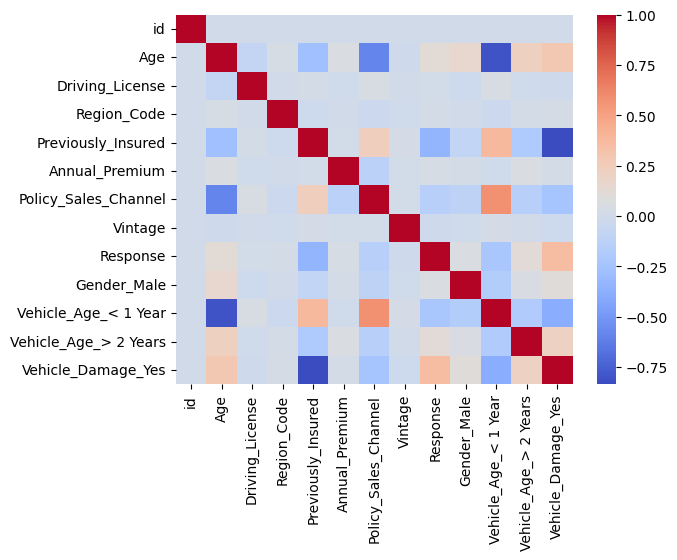

In [9]:
sns.heatmap(train.corr(), cmap='coolwarm', annot=False);

In [10]:
# Убираем признаки Previously_Insured и Vehicle_Age_< 1 Year, чтобы избежать переобучения, также убираем id за ненадобностью
train = train.drop(columns=['Previously_Insured', 'Vehicle_Age_< 1 Year', 'id'])

In [11]:
# One-hot кодирование категориальных признаков
categorical_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)
test

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
5000000,5000000,44,1,36.0,1,2630.0,152.0,182,0,False,False,False,False
5000001,5000001,61,1,28.0,0,41372.0,30.0,77,1,True,False,True,True
5000002,5000002,44,1,0.0,1,2630.0,122.0,107,0,True,False,False,False
5000003,5000003,25,1,28.0,0,2630.0,152.0,248,0,True,True,False,False
5000004,5000004,26,1,2.0,1,38414.0,160.0,24,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,48,1,6.0,0,27412.0,26.0,218,0,True,False,False,True
11504794,11504794,26,1,36.0,0,29509.0,152.0,115,1,False,True,False,True
11504795,11504795,29,1,32.0,1,2630.0,152.0,189,0,False,True,False,False
11504796,11504796,51,1,28.0,0,48443.0,26.0,274,1,False,False,False,True


In [12]:
X = train.drop(columns=['Response'])
y = train['Response']

X_test = test.drop(columns=['Response'])
y_test = test['Response']

In [13]:
# y.dropna(axis=0, how='any', inplace=False)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
models = {
     #'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
     #    'C': [0.01, 0.1, 1, 10]
     #}),
     #'DecisionTree': (DecisionTreeClassifier(random_state=42), {
     #    'max_depth': [5, 10, 20, None],
     #    'min_samples_split': [2, 5, 10]
     #}),
     'RandomForest': (RandomForestClassifier(random_state=42), {
         'n_estimators': [50],
         'max_depth': [None]
     }),
     'KNN': (KNeighborsClassifier(), {
         'n_neighbors': [3, 5, 7]
     }),
     'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
         'n_estimators': [50, 100],
         'max_depth': [3, 5, 7],
         'learning_rate': [0.01, 0.1]
     })
 }

#                 Model                                        Best_Params  \
# 1        DecisionTree        {'max_depth': None, 'min_samples_split': 2}
# 2        RandomForest            {'max_depth': None, 'n_estimators': 50}
# 4             XGBoost  {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...
# 3                 KNN                                 {'n_neighbors': 3}
# 0  LogisticRegression                                         {'C': 0.1}

#    Precision    Recall        F1
# 1   0.306073  0.323690  0.314635
# 2   0.431724  0.118442  0.185887
# 4   0.582594  0.038405  0.072060
# 3   0.135027  0.047369  0.070134
# 0   0.305772  0.036422  0.065091

In [16]:
results = []

for name, (model, params) in models.items():
    
    print(f"Training {name}...")
    
    # Grid search
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    
    with mlflow.start_run(run_name=name):

        grid.fit(X_train, y_train)

        y_pred = grid.predict(X_val)

        acc = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        roc_auc = roc_auc_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        mlflow.log_params(grid.best_params_)

        # Метрики качества
        mlflow.log_metric("accuracy", round(acc, 4))
        mlflow.log_metric("precision", round(precision, 4))
        mlflow.log_metric("recall", round(recall, 4))
        mlflow.log_metric("f1", round(f1, 4))
        mlflow.log_metric("roc_auc", round(roc_auc, 4))

        # Сохраняем модель
        try:
            mlflow.sklearn.log_model(grid.best_estimator_, f"{name}_model")
        except:
            print(f"Could not log model for {name}.")

        # Сохраняем результаты для сравнения
        results.append({
            'Model': name,
            'Best_Params': grid.best_params_,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
        })

Training RandomForest...


2025/12/12 18:52:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/12 18:56:18 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4f1t3hv5/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.7.2', 'cloudpickle==3.1.2']. Set logging level to DEBUG to see the full traceback. 
2025/12/12 18:56:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Could not log model for RandomForest.
🏃 View run RandomForest at: http://178.72.151.49:5050/#/experiments/2/runs/1b436847bc8a43faa956b2bdb7a928e0
🧪 View experiment at: http://178.72.151.49:5050/#/experiments/2
Training KNN...


2025/12/12 19:09:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/12 19:09:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run KNN at: http://178.72.151.49:5050/#/experiments/2/runs/51da432b97a74bc4b46d6cbb3e16fc06
🧪 View experiment at: http://178.72.151.49:5050/#/experiments/2
Training XGBoost...


/usr/local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [19:10:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [19:10:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [19:10:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [19:10:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: 

🏃 View run XGBoost at: http://178.72.151.49:5050/#/experiments/2/runs/99fe07721d7f484eb3632591da68ef99
🧪 View experiment at: http://178.72.151.49:5050/#/experiments/2
